In [ ]:
import torch
from torchvision import datasets, transforms
from torchvision.datasets import Food101
import os
import pathlib
import shutil

In [ ]:
# Data directory
data_dir = pathlib.Path("data")

In [ ]:
# Get training data
train_data = Food101(root=data_dir,
                              split="train",
                              download=True)

# Get testing data
test_data = Food101(root=data_dir,
                             split="test",
                             download=True)

100%|██████████| 4996278331/4996278331 [00:51<00:00, 96718344.37it/s]


Extracting data/food-101.tar.gz to data


In [ ]:
train_data, train_data.classes[:10]

(Dataset Food101
     Number of datapoints: 75750
     Root location: data
     split=train,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'])

Class name: hot_and_sour_soup


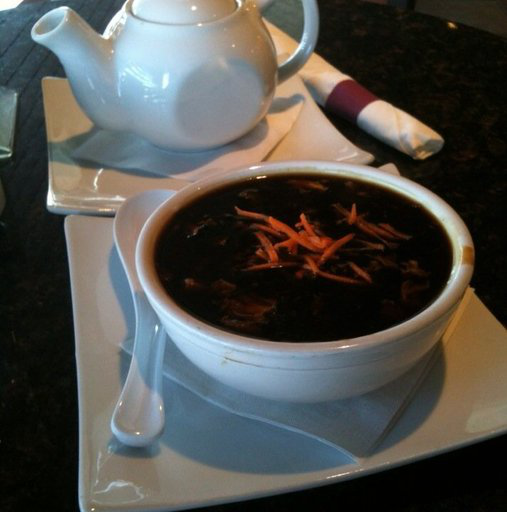

In [ ]:
# Viewing an image
image_index = 750
print(f"Class name: {train_data.classes[train_data[image_index][1]]}")
train_data[image_index][0]

In [ ]:
# Creating custom dataset that is the subset of the food101 dataset for testing purposes
data_path = data_dir / "food-101" / "images"
target_classes = ["pizza", "donuts", "steak", "french_fries", "sushi"]

data_splits=["train", "test"]

import random
random.seed(42)
label_splits = {}

for data_split in data_splits:
  print(f"Creating image split for: {data_split}...")
  label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
  with open(label_path, "r") as f:
      labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]

  number_to_sample = round(0.2 * len(labels))
  print(f"Getting random subset of {number_to_sample} images for {data_split}...")
  sampled_images = random.sample(labels, k=number_to_sample)

  image_paths = [pathlib.Path(str(data_path / sample_image) + ".jpg") for sample_image in sampled_images]
  label_splits[data_split] = image_paths

label_splits["train"][:10]

Creating image split for: train...
Getting random subset of 750 images for train...
Creating image split for: test...
Getting random subset of 250 images for test...


[PosixPath('data/food-101/images/steak/2796102.jpg'),
 PosixPath('data/food-101/images/donuts/3051684.jpg'),
 PosixPath('data/food-101/images/donuts/1503725.jpg'),
 PosixPath('data/food-101/images/sushi/1165660.jpg'),
 PosixPath('data/food-101/images/french_fries/2875570.jpg'),
 PosixPath('data/food-101/images/french_fries/2315325.jpg'),
 PosixPath('data/food-101/images/french_fries/1928660.jpg'),
 PosixPath('data/food-101/images/donuts/3879821.jpg'),
 PosixPath('data/food-101/images/sushi/1070104.jpg'),
 PosixPath('data/food-101/images/donuts/284542.jpg')]

In [ ]:
### Moving the images to dedicated folders

target_dir_name = f"data/custom_dataset_{str(int(0.2*100))}_percent"
print(f"Creating directory: '{target_dir_name}'")

# Setup the directories
target_dir = pathlib.Path(target_dir_name)

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

Creating directory: 'data/custom_dataset_20_percent'


In [ ]:
for image_split in label_splits.keys():
  for image_path in label_splits[str(image_split)]:
    dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
    if not dest_dir.parent.is_dir():
        dest_dir.parent.mkdir(parents=True, exist_ok=True)
    print(f"Copying {image_path} to {dest_dir}...")
    shutil.copy2(image_path, dest_dir)

Copying data/food-101/images/steak/2796102.jpg to data/custom_dataset_20_percent/train/steak/2796102.jpg...
Copying data/food-101/images/donuts/3051684.jpg to data/custom_dataset_20_percent/train/donuts/3051684.jpg...
Copying data/food-101/images/donuts/1503725.jpg to data/custom_dataset_20_percent/train/donuts/1503725.jpg...
Copying data/food-101/images/sushi/1165660.jpg to data/custom_dataset_20_percent/train/sushi/1165660.jpg...
Copying data/food-101/images/french_fries/2875570.jpg to data/custom_dataset_20_percent/train/french_fries/2875570.jpg...
Copying data/food-101/images/french_fries/2315325.jpg to data/custom_dataset_20_percent/train/french_fries/2315325.jpg...
Copying data/food-101/images/french_fries/1928660.jpg to data/custom_dataset_20_percent/train/french_fries/1928660.jpg...
Copying data/food-101/images/donuts/3879821.jpg to data/custom_dataset_20_percent/train/donuts/3879821.jpg...
Copying data/food-101/images/sushi/1070104.jpg to data/custom_dataset_20_percent/train/s

In [ ]:
train_dir = target_dir / "train"
test_dir = target_dir / "test"
train_dir

PosixPath('data/custom_dataset_20_percent/train')

In [ ]:
os.makedirs("scripts")

In [ ]:
%%writefile scripts/data_setup.py

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
  train_dir: str,
  test_dir: str,
  transform: transforms.Compose,
  batch_size: int,
  num_workers: int = NUM_WORKERS
):
  train_data = datasets.ImageFolder(train_dir, transform = transform)
  test_data = datasets.ImageFolder(test_dir, transform = transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(dataset = train_data,
                                batch_size = batch_size,
                                num_workers = num_workers,
                                shuffle = True,
                                pin_memory = True)

  test_dataloader = DataLoader(dataset = test_data,
                              batch_size = batch_size,
                              num_workers = num_workers,
                              shuffle = False,
                              pin_memory= True)

  return train_dataloader, test_dataloader, class_names

Writing scripts/data_setup.py


In [ ]:
%%writefile scripts/model_builder.py

import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 13 * 13,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

Writing scripts/model_builder.py


In [ ]:
%%writefile scripts/engine.py

from typing import Dict, List, Tuple

import torch

from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # Forward pass
    y_pred = model(x)

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Zero the grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimize the step
    optimizer.step()

    # Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  #Average loss per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

# A single test step function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (x, y) in enumerate (dataloader):
      x, y  = x.to(device), y.to(device)

      # Forward pass
      test_pred = model(x)

      # Calculate loss
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()

      # Calculate accuracy
      test_pred_labels = test_pred.argmax(dim = 1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Average
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device = torch.device) -> Dict[str, List[float]]:
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(f"Epoch: {epoch + 1} | Train loss: {train_loss: .4f} | Train Accuracy: {train_acc: .4f} | Test Loss: {test_loss: .4f} | Test Accuracy: {test_acc: .4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

Writing scripts/engine.py


In [ ]:
%%writefile scripts/utils.py

import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents = True,
                        exist_ok = True)

  assert model_name.endswith(".pth") or model_name.endswith(".pt")
  model_save_path = target_dir_path / model_name

  print(f"Saving model to: {model_save_path}")
  torch.save(obj = model.state_dict(),
             f = model_save_path)

Writing scripts/utils.py


In [ ]:
%%writefile scripts/train.py

import os
import torch
from torchvision import transforms
from timeit import default_timer as timer
import data_setup, engine, model_builder, utils

NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

train_dir = "/content/data/custom_dataset_20_percent/train"
test_dir = "/content/data/custom_dataset_20_percent/test"

device = "cuda" if torch.cuda.is_available() else "cpu"

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = data_transforms,
                                                                               batch_size = BATCH_SIZE)

model = model_builder.TinyVGG(input_shape = 3,
                              hidden_units = HIDDEN_UNITS,
                              output_shape = len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = LEARNING_RATE)

start_time = timer()

engine.train(model = model,
             train_dataloader = train_dataloader,
             test_dataloader = test_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             epochs = NUM_EPOCHS,
             device = device)

end_time = timer()
print(f"Total training time: {end_time - start_time: .3f} seconds")

utils.save_model(model = model,
                 target_dir = "models",
                 model_name = "no_augment_foodvision.pth")

Writing scripts/train.py


### Implementing Transfer Learning
We will be using pretrained weights of EfficientNet from the torchvision documentation.

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchvision
from scripts import data_setup, engine
from torch import nn
from timeit import default_timer as timer
from torchinfo import summary
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
from PIL import Image
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42),
torch.cuda.manual_seed(42)

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fd3adfadcc0>,
 ['donuts', 'french_fries', 'pizza', 'steak', 'sushi'])

In [ ]:
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 64.4MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = len(class_names), bias = True).to(device)
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)

In [ ]:
summary(model = model,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 5]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
start_time = timer()

results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 30,
                       device = device)

end_time = timer()
print(f"Total training time: {end_time - start_time: .3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | Train loss:  0.8326 | Train Accuracy:  0.6812 | Test Loss:  0.4909 | Test Accuracy:  0.8329
Epoch: 2 | Train loss:  0.3428 | Train Accuracy:  0.8841 | Test Loss:  0.4035 | Test Accuracy:  0.8648
Epoch: 3 | Train loss:  0.2834 | Train Accuracy:  0.9068 | Test Loss:  0.3942 | Test Accuracy:  0.8714
Epoch: 4 | Train loss:  0.2146 | Train Accuracy:  0.9260 | Test Loss:  0.3965 | Test Accuracy:  0.8774
Epoch: 5 | Train loss:  0.2057 | Train Accuracy:  0.9338 | Test Loss:  0.4437 | Test Accuracy:  0.8531
Epoch: 6 | Train loss:  0.1856 | Train Accuracy:  0.9466 | Test Loss:  0.3862 | Test Accuracy:  0.8909
Epoch: 7 | Train loss:  0.1654 | Train Accuracy:  0.9515 | Test Loss:  0.3596 | Test Accuracy:  0.8861
Epoch: 8 | Train loss:  0.1514 | Train Accuracy:  0.9414 | Test Loss:  0.4188 | Test Accuracy:  0.8434
Epoch: 9 | Train loss:  0.1404 | Train Accuracy:  0.9528 | Test Loss:  0.4098 | Test Accuracy:  0.8531
Epoch: 10 | Train loss:  0.1912 | Train Accuracy:  0.9368 | Test Loss:  0

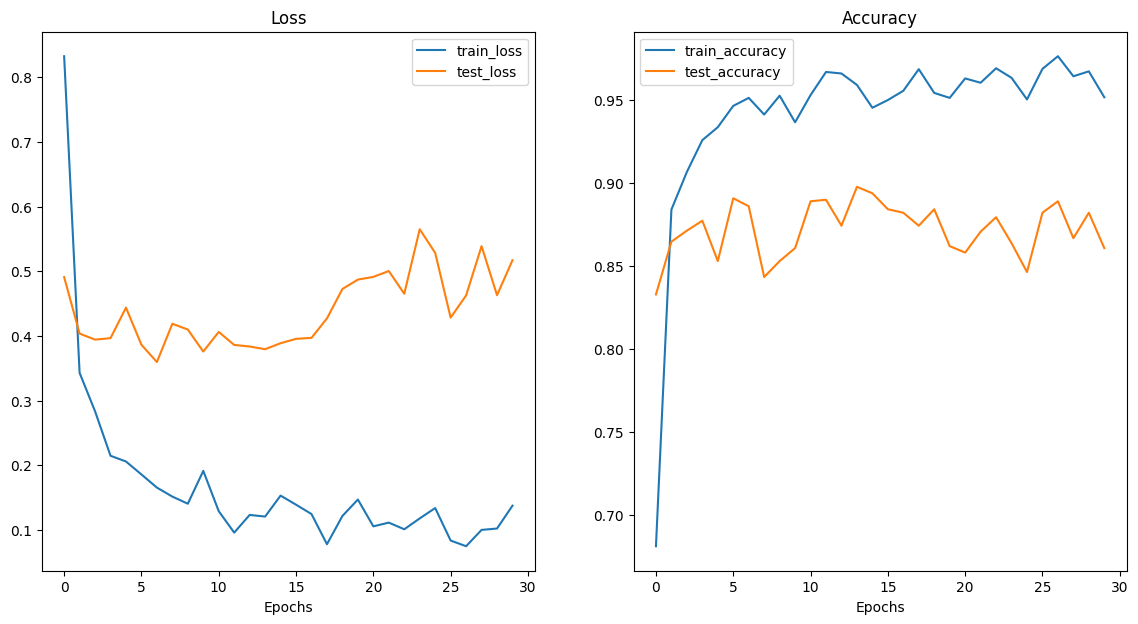

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize = (14,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs, test_accuracy, label = "test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

plot_loss_curves(results)

In [ ]:
### Predctions

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  img = Image.open(image_path)

  if transform:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image = image_transform(img).unsqueeze(0)
    target_image_pred = model(target_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  plt.figure()
  plt.imshow(img)
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max():.3f}"
  plt.title(title)
  plt.axis(False)

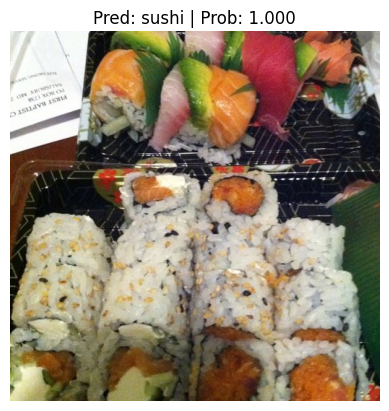

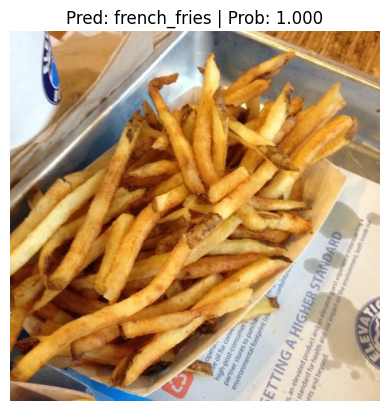

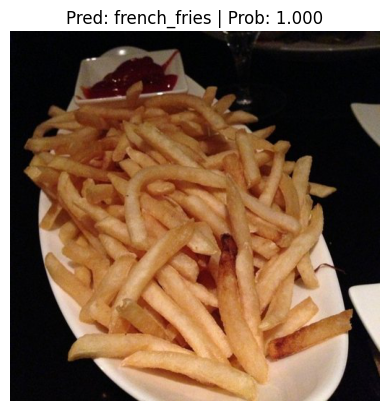

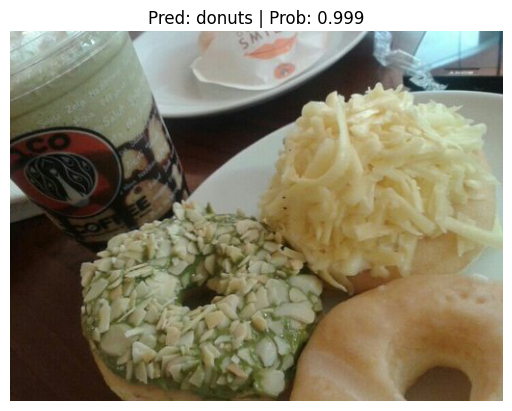

In [ ]:
num_test_images = 4
test_image_path_list = list(pathlib.Path(test_dir).glob("*/*.jpg"))
test_images_sample = random.sample(population = test_image_path_list,
                                   k = num_test_images)

for image_path in test_images_sample:
  pred_and_plot_image(model = model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (224, 224))

In [ ]:
from scripts import utils

utils.save_model(model, "models", "sample_foodvision.pth")

Saving model to: models/sample_foodvision.pth


In [ ]:
class_names

['donuts', 'french_fries', 'pizza', 'steak', 'sushi']